In [364]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [365]:
import numpy as np
import pandas as pd

In [366]:
import datetime as dt
# from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [367]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [368]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
Base.metadata.create_all(conn)


In [369]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)


In [370]:
# We can view all of the classes that automap found
for x in Base.classes:
    print(x)
Base.classes.keys()

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


['measurement', 'station']

In [371]:
# Save references to each table
mt = Base.classes.measurement
st = Base.classes.station

In [372]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [373]:
inspector=inspect(engine)

# # ##--------------------------------------------
m_columns=inspector.get_columns('measurement')

s_columns=inspector.get_columns('station')

print("measurement")
for m in m_columns:
    print(m)
    # print(m['name'],m['type'])
print('-----')
print("station")
for s in s_columns:
    print(s)
    # print(s['name'],s['type'])
# # ##--------------------------------------------


# ## just printing off a few dates so i can figure out the date format
# xxx = session.query(mt)
# counter = 0
# for t in xxx:
#     print(t.date)
#     print(type(t.date))
#     counter += 1
#     if counter == 5:
#         break
# print("------------------------------------")
# the_first_date = session.query(mt.date).first()

# print(the_first_date)
# print(type(the_first_date))
# the_first_date



measurement
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
-----
station
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, '

# Exploratory Climate Analysis

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


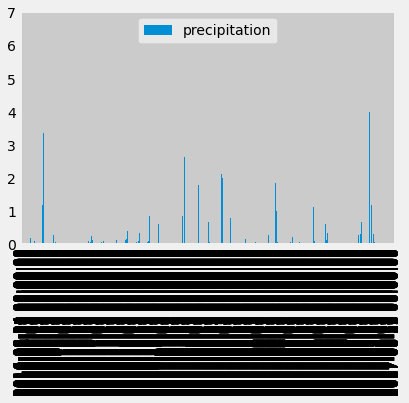

In [399]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

####getting the max day from the measurement table and converting it into datetime format
max_date = session.query(func.max(mt.date)).first()
max_date = max_date[0]
max_date = dt.datetime.strptime(max_date,'%Y-%m-%d')



# Calculate the date 1 year ago from the last data point in the database
year_ago =(max_date - dt.timedelta(weeks=52)).replace(day=max_date.day)

##### converting it into a format that we're able to query with
year_ago = f'{year_ago.year}-{year_ago.month:02d}-{year_ago.day:02d}'
year_ago


# Perform a query to retrieve the data and precipitation scores

annual_pre_list = session.query(mt.date,mt.prcp).filter(mt.date>year_ago).all()
# print(type(annual_pre_list))
# print(type(annual_pre_list[0][1]))



year_list =[pd.to_datetime(x,format='%Y-%m-%d') for x,y in annual_pre_list]
precip_list = [y for x,y in annual_pre_list]
print(type(year_list[0]))



# Save the query results as a Pandas DataFrame and set the index to the date column &  Sort the dataframe by date
annual_pre_df = pd.DataFrame({"precipitation":precip_list},index=year_list).sort_index()

annual_pre_df.head()





# Use Pandas Plotting with Matplotlib to plot the data

annual_pre_df.plot(kind="bar",figsize=(20,20))



In [ ]:
##### first draft of previous block

# year_ago=str(year_ago)
# max_day = engine.execute("SELECT MAX(measurement.date) FROM measurement").fetchall()
# max_day = engine.execute("SELECT MAX(measurement.date) FROM measurement").first()
# val = max_day[0]
# print(max_day)
# print(type(max_day))
# print(val)
# print(type(val))
# testday = "2020-01-01"
# test = engine.execute(f'SELECT * FROM measurement WHERE date ={testday}').fetchall()
# test
# for row in session.query(mt.date).filter_by(date=year_ago).all():
#     print(row)
# test=session.query(mt).filter_by(date=year_ago).all()
# test
# ## not working
# counter = 0
# for x in test:
#     print(x)
#     counter+=1
#     if counter == 5:
#         break
# print("is print working??")
# testy=session.query(mt).filter_by(date="2020-01-01").all()
# testy=session.query(mt).filter(mt.date=="2020-01-01").first()
# testy


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
